In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
# Upload data
df = pd.read_csv('../data/data_2011_2024.csv')
#df.info()

# Add population offset
df['log_pop'] = np.log(df['total_pop'])

### Descriptive statistics

In [3]:
dfminus2011 = df[df['year'] != 2011]
print(dfminus2011['case_count'].describe())

count    54444.000000
mean         1.417769
std         35.406201
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3093.000000
Name: case_count, dtype: float64


In [4]:
# Check for overdispersion
mean_count = dfminus2011['case_count'].mean()
var_count = dfminus2011['case_count'].var()
dispersion = var_count / mean_count

print(f"Mean: {mean_count:.2f}")
print(f"Variance: {var_count:.2f}")
print(f"Dispersion ratio (variance/mean): {dispersion:.2f}")
print("Skewness: ", skew(dfminus2011['case_count']))
print("Kurtosis: ", kurtosis(dfminus2011['case_count']))

# Count number of zeros
num_zeros = (dfminus2011['case_count'] == 0).sum()

# Calculate percentage of zeros
percent_zeros = (num_zeros / len(dfminus2011['case_count'])) * 100

print(f"Number of zeros: {num_zeros}")
print(f"Percentage of zeros: {percent_zeros:.2f}%")

Mean: 1.42
Variance: 1253.60
Dispersion ratio (variance/mean): 884.21
Skewness:  46.26496265854481
Kurtosis:  2687.648982741749
Number of zeros: 53009
Percentage of zeros: 97.36%


### Time series visualisation

In [5]:
# Create a datetime column for plotting
dfminus2011['date'] = pd.to_datetime(dfminus2011[['year', 'month']].assign(day=1))

/var/folders/xj/422_hdhn1bz0x9_khxxv4d100000gn/T/ipykernel_72012/3191439129.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfminus2011['date'] = pd.to_datetime(dfminus2011[['year', 'month']].assign(day=1))


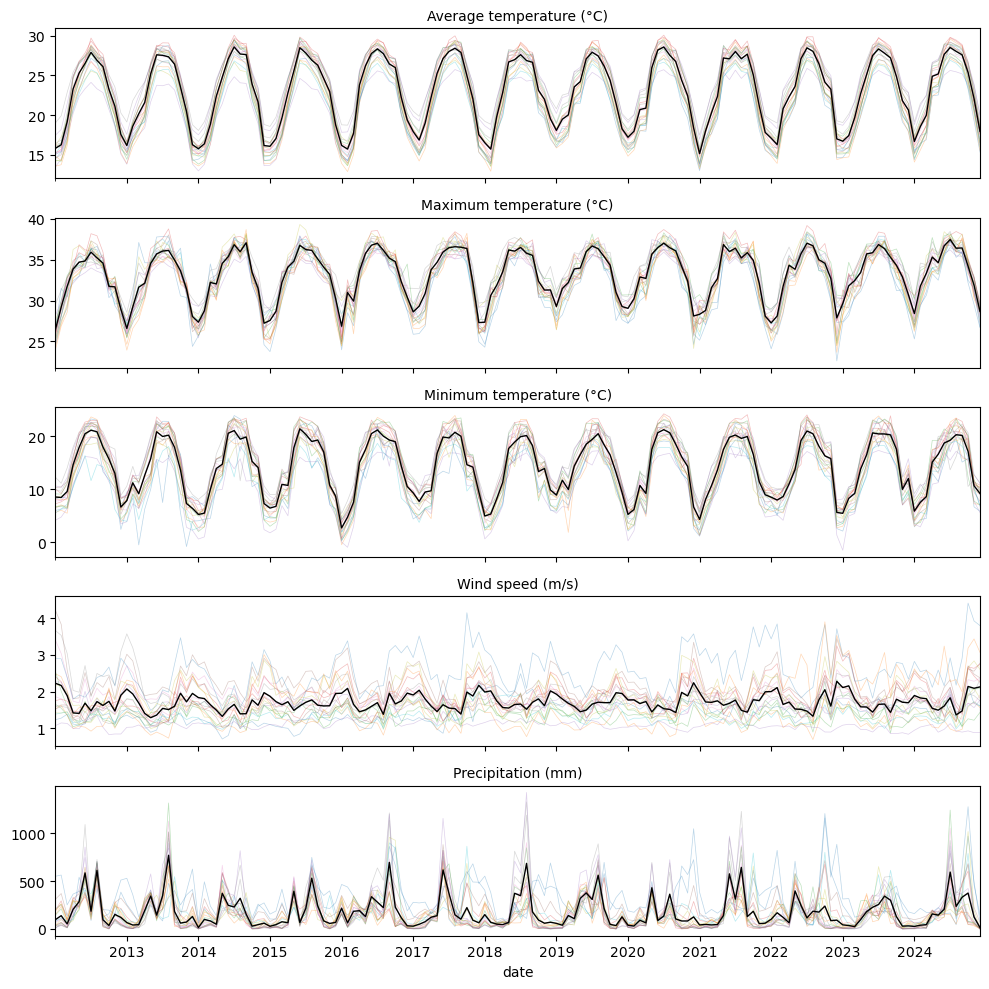

In [6]:
# Plot time series of climate variables and dengue cases
f, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
ax = ax.flatten()

cvariables = ['tavg', 'tmax', 'tmin', 'wind_speed', 'precip']
titles = ['Average temperature', 'Maximum temperature', 'Minimum temperature', 'Wind speed', 'Precipitation']
units = ['°C', '°C', '°C', 'm/s', 'mm']

for i, variable in enumerate(cvariables):
    # For each county, get the mean value of the variable for each date
    county_means = dfminus2011.groupby(['date', 'county'])[variable].mean().reset_index()
    
    # Create a pivot table with dates as index and counties as columns
    pivot_data = county_means.pivot(index='date', columns='county', values=variable)
    
    # Plot each county as a separate line
    pivot_data.plot(ax=ax[i], legend=False, alpha=0.3, linewidth=0.5)
    
    # Plot the overall mean as a thicker line
    overall_mean = dfminus2011.groupby('date')[variable].mean()
    overall_mean.plot(ax=ax[i], color='black', linewidth=1)
    
    ax[i].set_title(titles[i]+' ('+units[i]+')', fontsize=10)

# Add a common legend for the first plot
handles, labels = ax[0].get_legend_handles_labels()
#f.legend(handles[:1] + [handles[-1]], ['Individual counties', 'Overall mean'], loc='upper right', ncol=2)

# Set x-axis labels to show all years
unique_years = sorted(dfminus2011['year'].unique())
unique_years = [year for year in unique_years if year != 2012]
ax[-1].set_xticks(pd.to_datetime([f'{year}-01-01' for year in unique_years]))
ax[-1].set_xticklabels(unique_years)

plt.tight_layout()

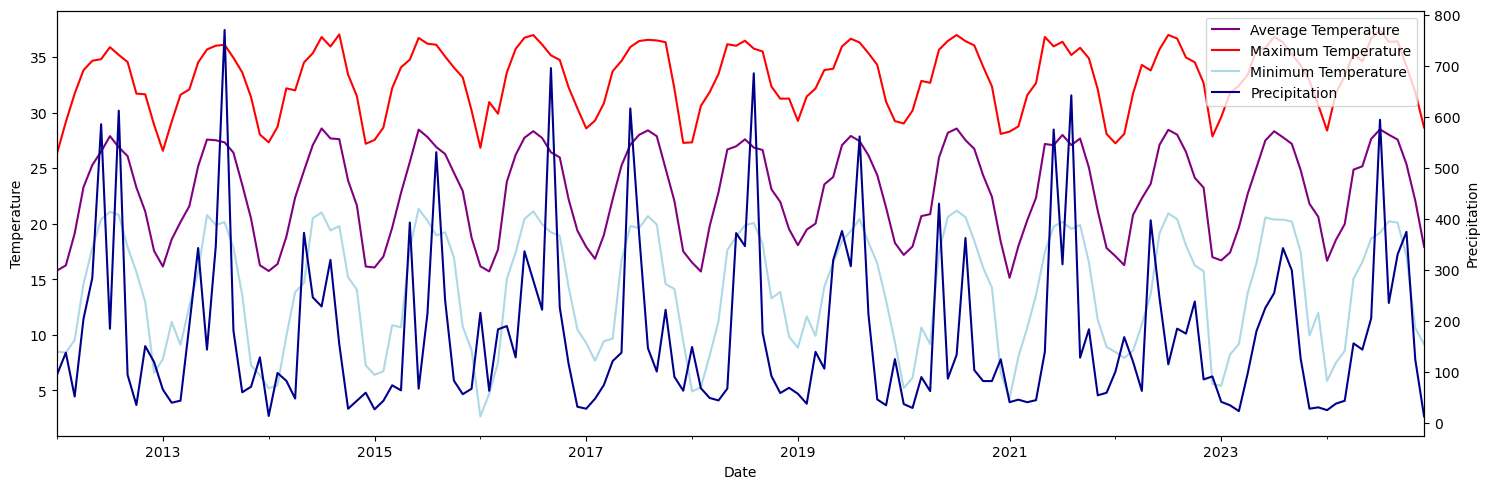

In [7]:
# Create df with climate variables and case counts aggregated by month (for all townships)
ts = pd.DataFrame()
for var in ['case_count', 'tavg', 'tmax', 'tmin', 'wind_speed', 'precip']:
    # Summarise cases
    if var == 'case_count':
        ts[var] = dfminus2011.groupby('date')[var].sum()
    # Mean of climatic variables
    else:
        ts[var] = dfminus2011.groupby('date')[var].mean()

f, ax1 = plt.subplots(figsize=(15, 5))
line1 = ts['tavg'].plot(color='purple', ax=ax1, label='Average Temperature')
line2 = ts['tmax'].plot(color='red', ax=ax1, label='Maximum Temperature')
line3 = ts['tmin'].plot(color='lightblue', ax=ax1, label='Minimum Temperature')

ax2 = ax1.twinx()
line4 = ts['precip'].plot(color='darkblue', ax=ax2, label='Precipitation')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Set labels for both y-axes
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Precipitation')
ax1.set_xlabel('Date')

plt.tight_layout()

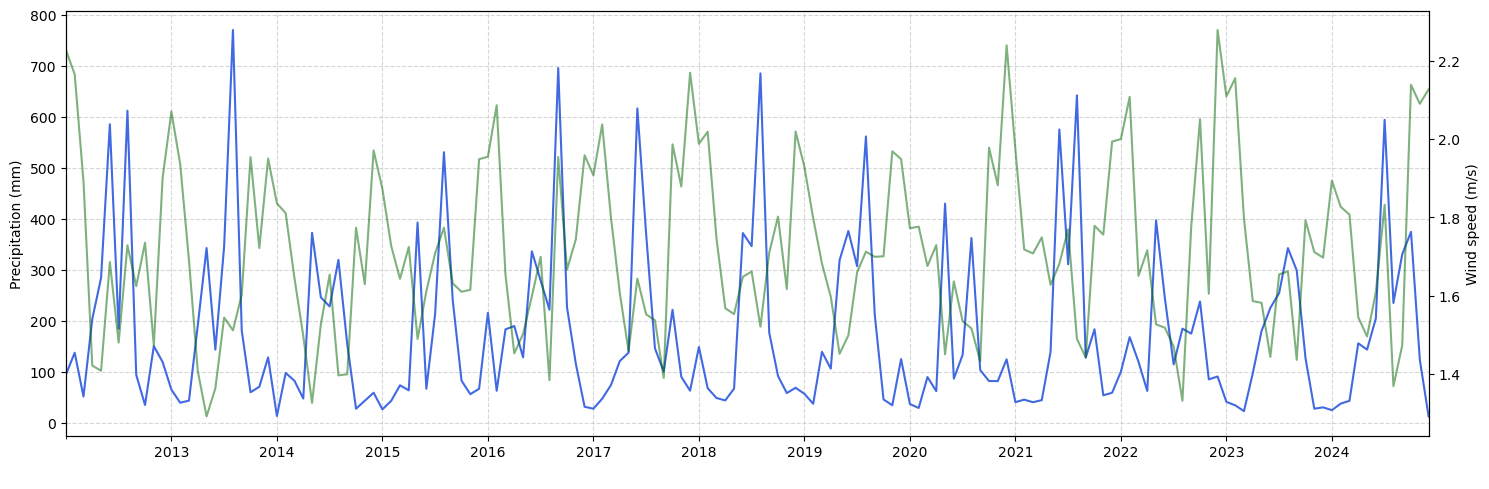

In [8]:
f, ax1 = plt.subplots(figsize=(15, 5))
line1 = ts['precip'].plot(color='royalblue', ax=ax1, label='Precipitation')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_xlabel(' ')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
line2 = ts['wind_speed'].plot(color='darkgreen', alpha=.5, ax=ax2, label='Wind speed')
ax2.set_ylabel('Wind speed (m/s)')


ax1.set_xticks(pd.to_datetime([f'{year}-01-01' for year in unique_years]))
ax1.set_xticklabels(unique_years)

plt.tight_layout()

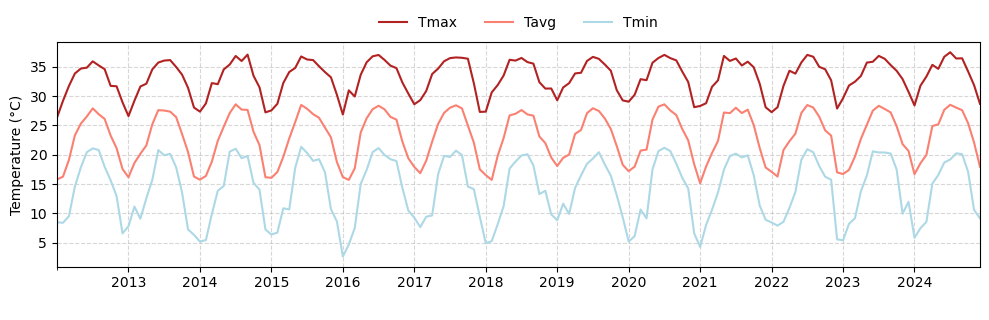

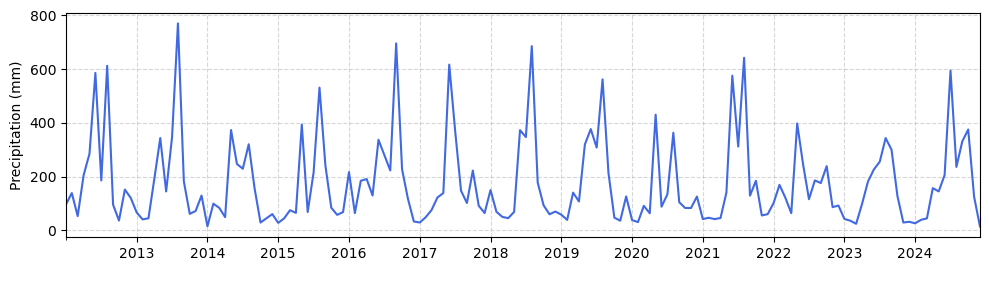

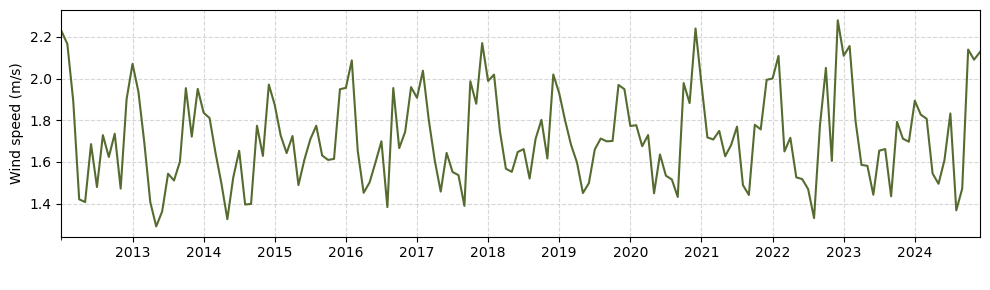

In [9]:
f, ax1 = plt.subplots(figsize=(10, 3.3))

line1 = ts['tmax'].plot(color='firebrick', ax=ax1, label='Tmax')
line2 = ts['tavg'].plot(color='salmon', ax=ax1, label='Tavg')
line3 = ts['tmin'].plot(color='lightblue', ax=ax1, label='Tmin')

# Add grid to the plot
ax1.grid(True, linestyle='--', alpha=0.5)

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, 
           loc='lower center', 
           bbox_to_anchor=(0.5, 1), 
           ncol=3, 
           frameon=False)

# Set labels for both y-axes
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel(' ')

# Set x-axis labels to show all years
unique_years = sorted(dfminus2011['year'].unique())
unique_years = [year for year in unique_years if year != 2012]  # Exclude 2012
ax1.set_xticks(pd.to_datetime([f'{year}-01-01' for year in unique_years]))
ax1.set_xticklabels(unique_years)

# Add bold letter 'a' to upper right corner
#ax1.text(-0.04, 1.13, 'a', transform=ax1.transAxes, fontsize=14, fontweight='bold', ha='left', va='top')

plt.tight_layout()
plt.savefig('../figs/annual_temp.svg', bbox_inches='tight', dpi=96)

# Precipitation
f, ax2 = plt.subplots(figsize=(10, 3))

line4 = ts['precip'].plot(color='royalblue', ax=ax2, label='Precipitation')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_ylabel('Precipitation (mm)')
ax2.set_xlabel(' ')
ax2.set_xticks(pd.to_datetime([f'{year}-01-01' for year in unique_years]))
ax2.set_xticklabels(unique_years)

plt.tight_layout()
plt.savefig('../figs/annual_precip.svg', bbox_inches='tight', dpi=96)

# Wind speed
f, ax3 = plt.subplots(figsize=(10, 3))

line5 = ts['wind_speed'].plot(color='darkolivegreen', ax=ax3, label='Wind speed')
ax3.set_ylabel('Wind speed (m/s)')
ax3.set_xlabel(' ')
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.set_xticks(pd.to_datetime([f'{year}-01-01' for year in unique_years]))
ax3.set_xticklabels(unique_years)

plt.tight_layout()
plt.savefig('../figs/annual_wind_speed.svg', bbox_inches='tight', dpi=96)

### Time series correlation

In [10]:
ts.corr(method='spearman')

,case_count,tavg,tmax,tmin,wind_speed,precip
case_count,1.000000,0.197902,0.145120,0.244314,-0.167301,0.164864
tavg,0.197902,1.000000,0.966500,0.965662,-0.667361,0.663372
tmax,0.145120,0.966500,1.000000,0.914801,-0.643205,0.651976
tmin,0.244314,0.965662,0.914801,1.000000,-0.641261,0.665837
wind_speed,-0.167301,-0.667361,-0.643205,-0.641261,1.000000,-0.457562
precip,0.164864,0.663372,0.651976,0.665837,-0.457562,1.000000


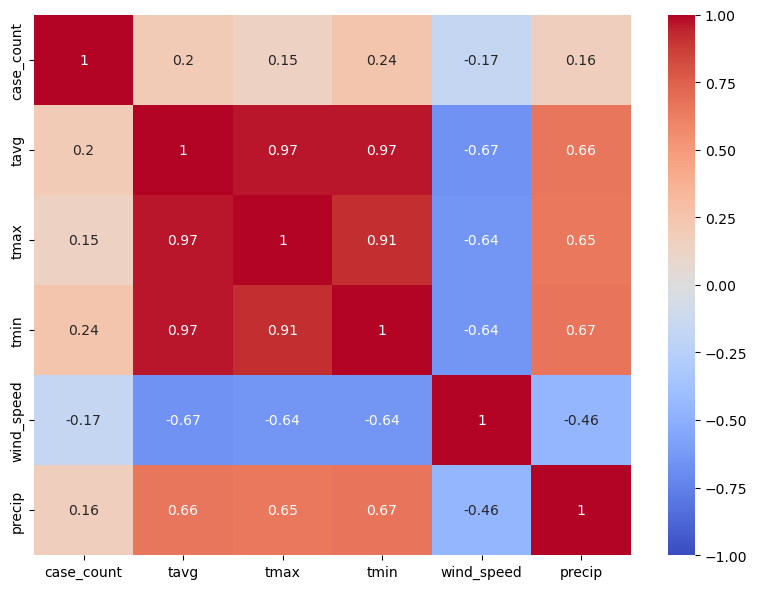

In [11]:
# Create correlation matrix
plt.figure(figsize=(8, 6))
corr_matrix = ts.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()

In [12]:
# Calculate lag for each climate variable
for i in range(5):
    for lag in range(6):
        ts[f'{cvariables[i]}_lag{lag+1}'] = ts[cvariables[i]].shift(periods=lag+1)

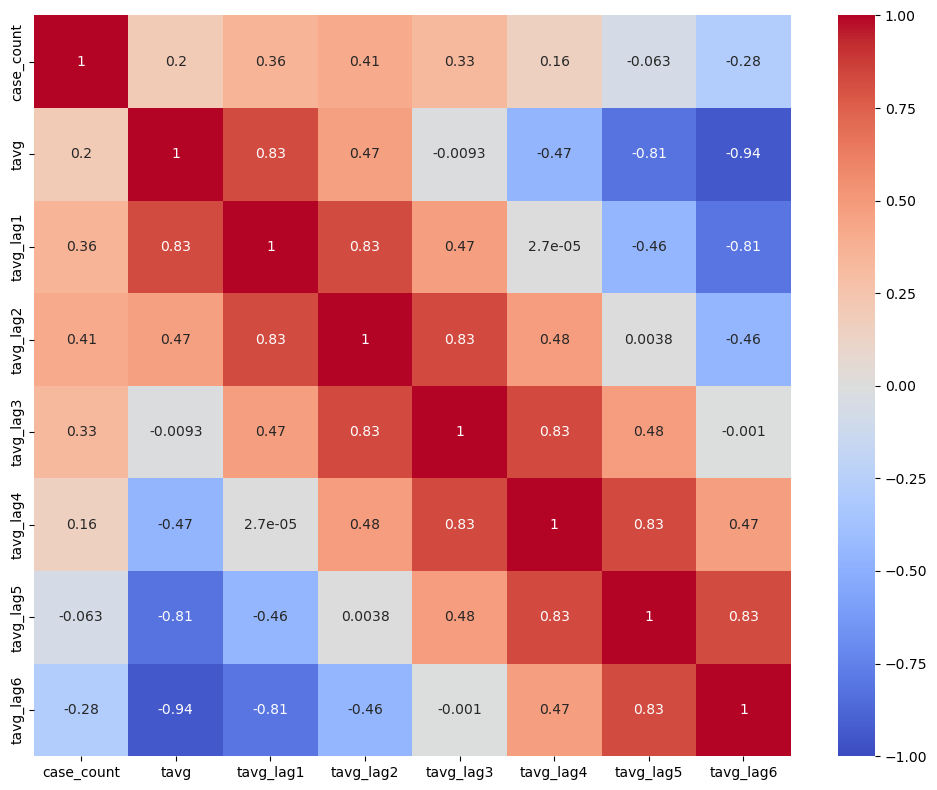

In [13]:
variables_tavg = ['case_count', 'tavg', 'tavg_lag1', 'tavg_lag2', 'tavg_lag3', 'tavg_lag4', 'tavg_lag5', 'tavg_lag6']
# Create correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = ts[variables_tavg].corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()

### Negative Binomial Regression

In [14]:
# Calculate lag for each climate variable
for i in range(5):
    for lag in range(4):
        df[f'{cvariables[i]}_lag{lag+1}'] = df[cvariables[i]].shift(periods=lag+1)

# Remove 2011 after calculating lag
df = df[df['year'] != 2011]

In [15]:
# Model 1: Basic model 
nbi_model = smf.glm(
    formula="case_count ~ tavg + tmax + tmin + wind_speed + precip + elevation + built_up_area", 
    data=df,
    family=sm.families.NegativeBinomial(alpha=.5),
    offset=df['log_pop']
)
results1 = nbi_model.fit()
print("\nNegative Binomial Model Results (without lag):")
print(results1.summary())

# Model 2: Basic model with lag+1
nbi_model = smf.glm(
    formula="case_count ~ tavg_lag1 + tmax_lag1 + tmin_lag1 + wind_speed_lag1 + precip_lag1 + elevation + built_up_area", 
    data=df,
    family=sm.families.NegativeBinomial(),
    offset=df['log_pop']
)
results2 = nbi_model.fit()
print("\nNegative Binomial Model Results (1-month lag):")
print(results2.summary())

# Model 3: Basic model with lag+2
nbi_model = smf.glm(
    formula="case_count ~ tavg_lag2 + tmax_lag2 + tmin_lag2 + wind_speed_lag2 + precip_lag2 + elevation + built_up_area", 
    data=df,
    family=sm.families.NegativeBinomial(),
    offset=df['log_pop']
)
results3 = nbi_model.fit()
print("\nNegative Binomial Model Results (2-month lag):")
print(results3.summary())

# Model 4: Basic model with lag+3
nbi_model = smf.glm(
    formula="case_count ~ tavg_lag3 + tmax_lag3 + tmin_lag3 + wind_speed_lag3 + precip_lag3 + elevation + built_up_area", 
    data=df,
    family=sm.families.NegativeBinomial(),
    offset=df['log_pop']
)
results4 = nbi_model.fit()
print("\nNegative Binomial Model Results (3-month lag):")
print(results4.summary())


Negative Binomial Model Results (without lag):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             case_count   No. Observations:                54444
Model:                            GLM   Df Residuals:                    54436
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60558.
Date:                Sun, 08 Jun 2025   Deviance:                   1.1363e+05
Time:                        23:29:28   Pearson chi2:                 3.80e+09
No. Iterations:                    38   Pseudo R-squ. (CS):             0.6268
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Negative Binomial Model Results (1-month lag):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             case_count   No. Observations:                54444
Model:                            GLM   Df Residuals:                    54436
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38842.
Date:                Sun, 08 Jun 2025   Deviance:                       69420.
Time:                        23:29:30   Pearson chi2:                 7.09e+06
No. Iterations:                    35   Pseudo R-squ. (CS):             0.5823
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Negative Binomial Model Results (2-month lag):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             case_count   No. Observations:                54444
Model:                            GLM   Df Residuals:                    54436
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33764.
Date:                Sun, 08 Jun 2025   Deviance:                       59264.
Time:                        23:29:31   Pearson chi2:                 4.32e+06
No. Iterations:                    36   Pseudo R-squ. (CS):             0.6534
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Negative Binomial Model Results (3-month lag):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             case_count   No. Observations:                54444
Model:                            GLM   Df Residuals:                    54436
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33705.
Date:                Sun, 08 Jun 2025   Deviance:                       59146.
Time:                        23:29:32   Pearson chi2:                 1.00e+07
No. Iterations:                    36   Pseudo R-squ. (CS):             0.6541
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

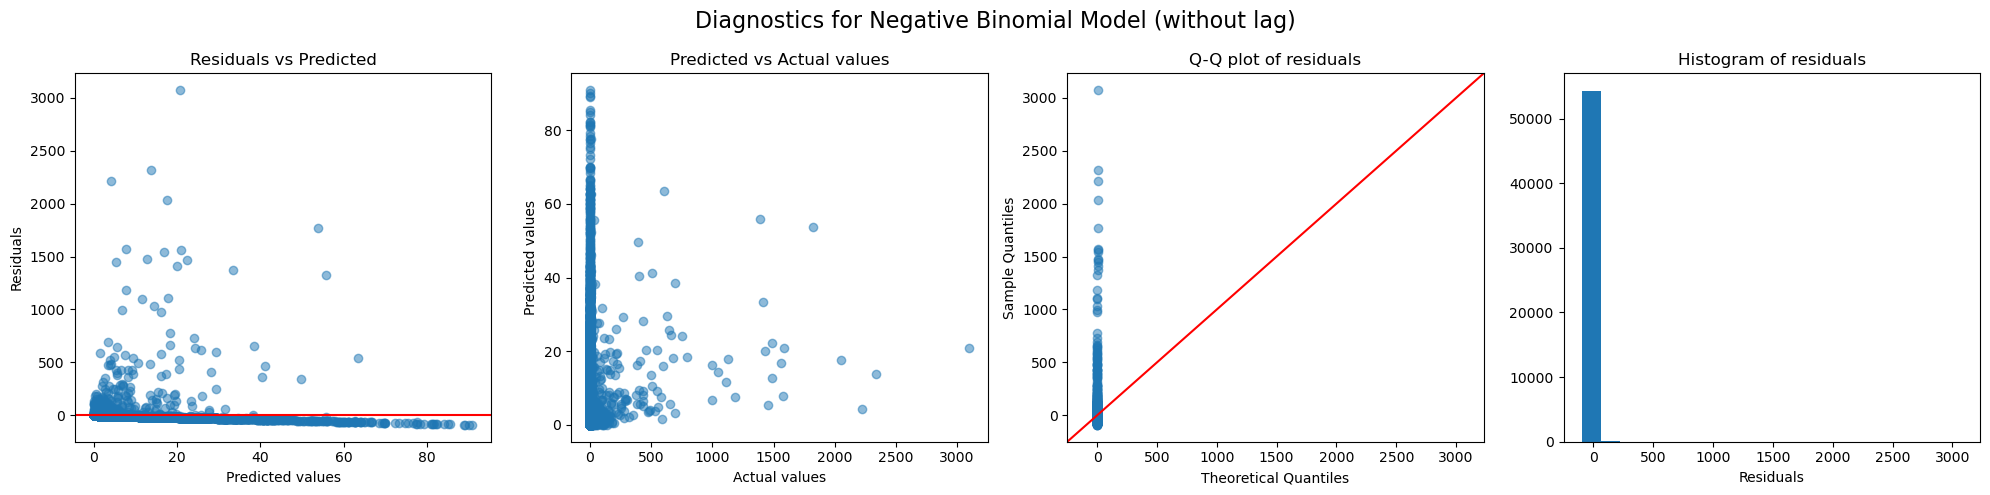

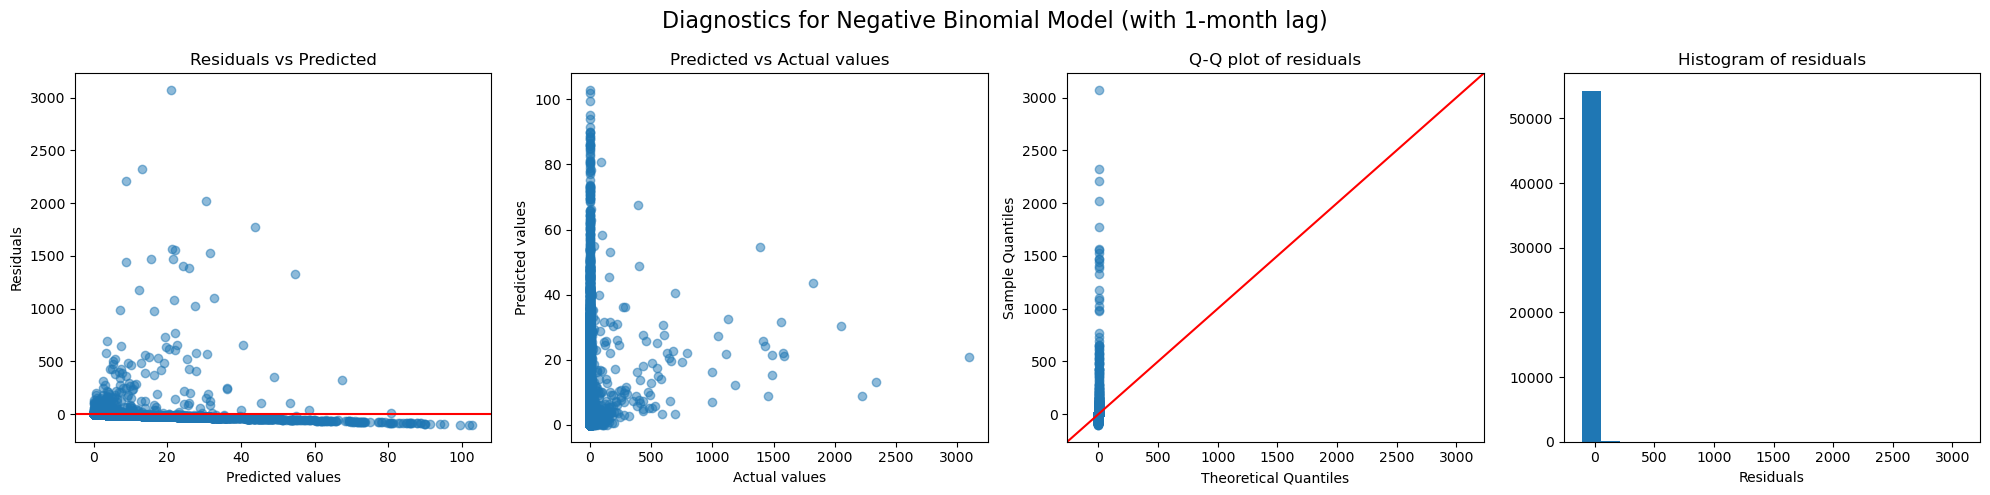

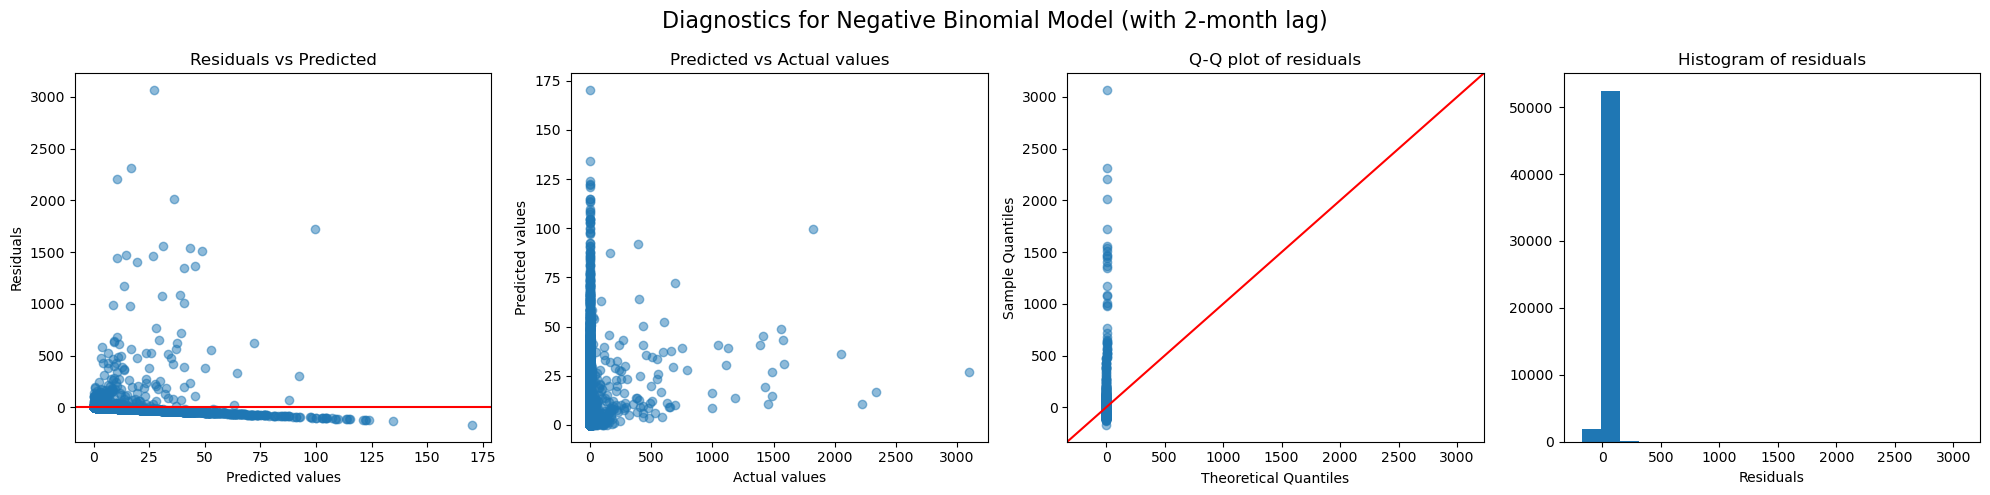

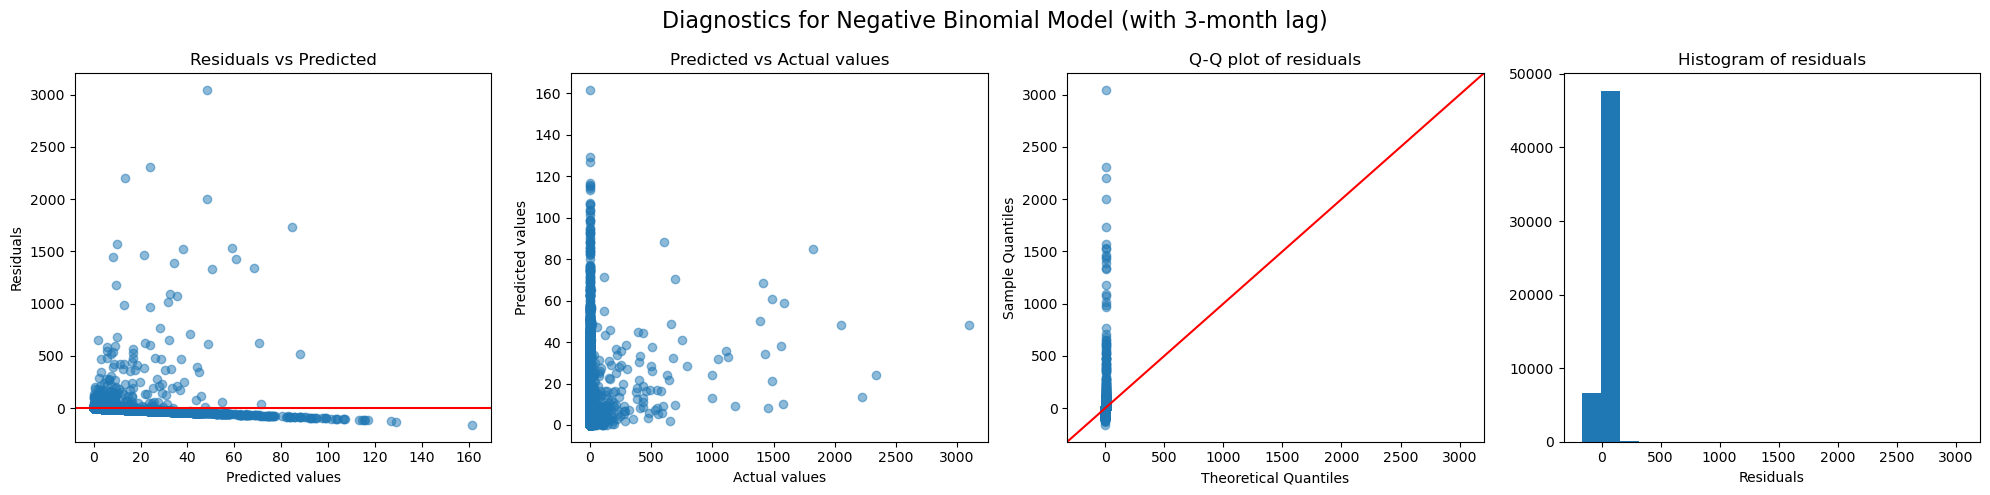

In [16]:
# Examine residuals for model diagnostics
results = [results1, results2, results3, results4]
model_names = ['Negative Binomial Model (without lag)', 'Negative Binomial Model (with 1-month lag)', 
                'Negative Binomial Model (with 2-month lag)', 'Negative Binomial Model (with 3-month lag)']

for i, result in enumerate(results):
    f, ax = plt.subplots(1, 4, figsize=(20, 5))

    # Generate predicted values
    df['predicted'] = result.predict()

    # Residuals
    ax[0].scatter(df['predicted'], df['case_count'] - df['predicted'], alpha=.5)
    ax[0].axhline(y=0, color='r', linestyle='-')
    ax[0].set_title('Residuals vs Predicted')
    ax[0].set_xlabel('Predicted values')
    ax[0].set_ylabel('Residuals')

    # Actual vs predicted
    ax[1].scatter(df['case_count'], df['predicted'], alpha=.5)
    max_val = max(df['case_count'].max(), df['predicted'].max())
    #ax[1].plot([0, max_val], [0, max_val], 'r--')
    ax[1].set_title('Predicted vs Actual values')
    ax[1].set_xlabel('Actual values')
    ax[1].set_ylabel('Predicted values')

    # Q-Q plot
    sm.qqplot(df['case_count'] - df['predicted'], line='45', ax=ax[2], alpha=.5)
    ax[2].set_title('Q-Q plot of residuals')

    # Histogram of residuals
    ax[3].hist(df['case_count'] - df['predicted'], bins=20)
    ax[3].set_title('Histogram of residuals')
    ax[3].set_xlabel('Residuals')

    plt.suptitle(f"Diagnostics for {model_names[i]}", fontsize=16)
    plt.tight_layout()